本檔案使用資料處理後的Mel頻譜圖進行訓練與預測

為了滿足預訓練模型所需，在進入模型之前先將影像疊為三通道。

訓練結果的模型權重將存為「mels.h5'」

In [ ]:
from tqdm import tqdm, notebook
import librosa
# from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import glob 
import numpy as np
from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean, median
import shutil
from scipy.io import wavfile
from scipy.fftpack import dct

from scipy.io import wavfile
from scipy.fftpack import dct
import os


import scipy.signal 
import scipy.io.wavfile
import io 
import IPython
from IPython.display import Image
import math
import numpy.matlib
import joblib

import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.inspection import permutation_importance
import random
import pandas as pd

from sklearn import metrics
import pickle
import csv
from sklearn.model_selection import train_test_split
import audioflux as af

import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras_self_attention import SeqSelfAttention
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dropout,Layer,Concatenate,Input,Activation
from tensorflow.keras.layers import BatchNormalization,LayerNormalization,LeakyReLU,ReLU,Add,AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, multiply, add, GlobalMaxPooling1D, Multiply
from tensorflow.keras.layers import Masking, Bidirectional, LSTM
from tensorflow.keras.applications import EfficientNetB4
from focal_loss import SparseCategoricalFocalLoss
import joblib
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import h5py
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


In [2]:
#求取 HNR值
import parselmouth
from parselmouth.praat import call
unit = "Hertz"
                                                #HNR的副程式，計算完成後回傳HNR值                          
def getHnr(filename, unit):
    sound = parselmouth.Sound(filename) # read the sound
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 60, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)

    return hnr

# getHnr(r"test_1121202\E\1\NO. 004_0.wav", unit)

#計算CPP參數
def cpp(x, fs, pitch_range): 
    """
    Computes cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    pitch_range: list of 2 elements
        The pitch range where a peak is searched for

    Returns
    -----------
    float
        The cepstral peak prominence of the audio signal
    """
    # Quefrency
    frameLen = len(x)
    NFFT = 2**(math.ceil(np.log(frameLen)/np.log(2)))
    quef = np.linspace(0, frameLen/1000, NFFT)

    # Allowed quefrency range
    quef_lim = [int(np.round_(fs/pitch_range[1])), int(np.round_(fs/pitch_range[0]))]
    quef_seq = range(quef_lim[0]-1, quef_lim[1])
    
    # High-pass filtering
    HPfilt_b = [1 - 0.97]
    x = scipy.signal.lfilter( HPfilt_b, 1, x )
    
    # FrameMat
    frameMat = np.zeros(NFFT)
    frameMat[0: frameLen] = x

    # Hanning
    def hanning(N):
        x = np.array([i/(N+1) for i in range(1,int(np.ceil(N/2))+1)])
        w = 0.5-0.5*np.cos(2*np.pi*x)
        w_rev = w[::-1]
        return np.concatenate((w, w_rev[int((np.ceil(N%2))):]))
    win = hanning(frameLen)
    winmat = np.matlib.repmat(win, 1, 1)
    frameMat = frameMat[0:frameLen]*winmat
    frameMat = frameMat[0]
    
    # Cepstrum
    SpecMat = np.abs(np.fft.fft(frameMat))
    SpecdB = 20*np.log10(SpecMat)
    ceps = 20*np.log10(np.abs(np.fft.fft(SpecdB)))
    
    # Finding the peak
    ceps_lim = ceps[quef_seq]
    ceps_max = np.max(ceps_lim)
    max_index = np.argmax(ceps_lim)

    # Normalisation
    ceps_mean = np.mean(ceps_lim)
    p = np.polyfit(quef_seq, ceps_lim,1)
    ceps_norm = np.polyval(p, quef_seq[max_index])

    cpp = ceps_max-ceps_norm
    # print(cpp)
    return cpp

def cpp_plot(x, fs, pitch_range): 
    """
    Plots the cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    pitch_range: list of 2 elements
        The pitch range where a peak is searched for

    """
    # Quefrency
    frameLen = len(x)
    NFFT = 2**(math.ceil(np.log(frameLen)/np.log(2)))
    quef = np.linspace(0, frameLen/1000, NFFT)

    # Allowed quefrency range
    quef_lim = [int(np.round_(fs/pitch_range[1])), int(np.round_(fs/pitch_range[0]))]
    quef_seq = range(quef_lim[0]-1, quef_lim[1])
    
    # High-pass filtering
    HPfilt_b = [1 - 0.97]
    x = scipy.signal.lfilter( HPfilt_b, 1, x )
    
    # FrameMat
    frameMat = np.zeros(NFFT)
    frameMat[0: frameLen] = x

    # Hanning
    def hanning(N):
        x = np.array([i/(N+1) for i in range(1,int(np.ceil(N/2))+1)])
        w = 0.5-0.5*np.cos(2*np.pi*x)
        w_rev = w[::-1]
        return np.concatenate((w, w_rev[int((np.ceil(N%2))):]))
    win = hanning(frameLen)
    winmat = np.matlib.repmat(win, 1, 1)
    frameMat = frameMat[0:frameLen]*winmat
    frameMat = frameMat[0]
    
    # Cepstrum
    SpecMat = np.abs(np.fft.fft(frameMat))
    SpecdB = 20*np.log10(SpecMat)
    ceps = 20*np.log10(np.abs(np.fft.fft(SpecdB)))
    
    # Finding the peak
    ceps_lim = ceps[quef_seq]
    ceps_max = np.max(ceps_lim)
    max_index = np.argmax(ceps_lim)

    # Normalisation
    ceps_mean = np.mean(ceps_lim)
    p = np.polyfit(quef_seq, ceps_lim,1)
    ceps_norm = np.polyval(p, quef_seq[max_index])

    cpp = ceps_max-ceps_norm
    
    print('ceps_max: {}'.format(ceps_max))
    print('ceps_norm: {}'.format(ceps_norm))
    print('cpp: {}'.format(cpp))
    #print(format(cpp))
    # Plotting 
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(quef[quef_seq], ceps_lim)
    ax.plot(quef[quef_seq], np.poly1d(p)(quef_seq))
    ax.plot(quef[quef_seq][max_index], ceps_max, marker="o",markeredgecolor="red", markerfacecolor="red")
    ax.plot(quef[quef_seq][max_index], np.poly1d(p)(quef_seq)[max_index], marker="o", markeredgecolor="red", markerfacecolor="red")

    ax.set_xlabel('quefrency(s)')
    ax.set_ylabel('log magnitude(dB)')
    ax.set_title('Cepstrum')

#MPT detection
#判斷聲音是否過短，若過短的話，可直接判成severity_3，資料不送進model訓練

class soundBase:
    def __init__(self, path):
        self.path = path

    def audioread(self, formater='sample'):
        """
        读取语音文件
        2020-2-26   Jie Y.  Init
        这里的wavfile.read()函数修改了里面的代码，返回项return fs, data 改为了return fs, data, bit_depth
        如果这里报错，可以将wavfile.read()修改。
        :param formater: 获取数据的格式，为sample时，数据为float32的，[-1,1]，同matlab同名函数. 否则为文件本身的数据格式
                        指定formater为任意非sample字符串，则返回原始数据。
        :return: 语音数据data, 采样率fs，数据位数bits
        """
        fs, data = wavfile.read(self.path)
        if formater == 'sample':
            data = data / (2 ** (16 - 1))
        return data, fs

    def SPL(self, data, fs, frameLen=50,   isplot=False):
        """
        计算声压曲线
        2020-2-26   Jie Y.  Init
        :param data: 语音信号数据
        :param fs: 采样率
        :param frameLen: 计算声压的时间长度(ms单位)
        :param isplot: 是否绘图，默认是
        :return: 返回声压列表spls
        """
                                     #計算發音有效時間的副程式
        def spl_cal(s, fs, frameLen):
            """
            根据数学公式计算单个声压值
            $y=\sqrt(\sum_{i=1}^Nx^2(i))$
            2020-2-26   Jie Y. Init
            :param s: 输入数据
            :param fs: 采样率
            :param frameLen: 计算声压的时间长度(ms单位)
            :return: 单个声压数值
            """
            l = len(s)
            M = frameLen * fs / 1000
            if not l == M:
                exit('输入信号长度与所定义帧长不等！')
                                                     # 计算有效声压
            pp = 0
            for i in range(int(M)):
                pp += (s[i] * s[i])
            pa = np.sqrt(pp / M)
            p0 = 2e-5
            spl = 20 * np.log10(pa / p0)
            return spl

        #計算各個frame 的MPT
        length = len(data)
        M = fs * frameLen // 1000
        m = length % M
        if not m < M // 2:
            # 最后一帧长度不小于M的一半
            data = np.hstack((data, np.zeros(M - m)))
        else:
            # 最后一帧长度小于M的一半
            data = data[:M * (length // M)]
        spls = np.zeros(len(data) // M)
        total=0
        for i in range(length // M - 1):
            
            s = data[i * M:(i + 1) * M]
            spls[i] = spl_cal(s, fs, frameLen)   #副程式會接收由spl_call傳回來的數值(spl), 並存於的矩陣(spls)中
            
            if (spls[i]>(0.8*(np.max(spls)))):
                total=total+1
                

        if isplot:
            plt.subplot(211)
            plt.plot(data)
            plt.subplot(212)
            plt.step([i for i in range(len(spls))], spls) #逐幀地印出矩陣的內容
            plt.show()
            
        #for i in range(length // M - 1):  
         #   if (spls[i]<((np.max(spls)))):
          #      total=total+1
        MPT=total*0.05
#         print(total)
        return total

# sb = soundBase(r"test_1121202\E\1\NO. 004_0.wav")
# data, fs = sb.audioread()
# sb.SPL(data, fs, isplot = True)

In [3]:
def gelu(x):
        return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x * x * x)))

def spatialAttention_eff(input_feature,kernel_size=7,name=""):
    cbam_feature=input_feature
    avg_pool=tf.reduce_mean(input_feature,axis=3,keepdims=True) 
    max_pool=tf.reduce_max(input_feature,axis=3,keepdims=True)
    concat=Concatenate(axis=3)([avg_pool,max_pool])
    cbam_feature=Conv2D(filters=112,kernel_size=7,strides=1,padding='same',use_bias=False,name="spatial_attention_" + str(name), dilation_rate=2)(concat)
    cbam_feature=Activation('sigmoid')(cbam_feature)
    out=Multiply()([input_feature,cbam_feature])
    return out

def residual_block_eff(x, filters, conv_num=3, activation="relu"):
    s = Conv2D(filters, 1, padding="same", dilation_rate=12)(x)  # 5
    for i in range(conv_num - 1):
        x = Conv2D(filters, 3, padding="same", dilation_rate=12)(x)
        x = ReLU()(x)
        x = Conv2D(filters, 3, padding="same", dilation_rate=12)(x)
        x = Add()([x, s])
        x = ReLU()(x)
    return MaxPooling2D(pool_size=3, strides=2,name='residual_end')(x)

# 4個數字的檔名
def get_full_filenames(df, folder_path):
    full_filenames = []
    for short_filename in df['ID']:
        full_path = os.path.join(folder_path, f"{short_filename}.wav")
        if os.path.exists(full_path):
            full_filenames.append(full_path)
        else:
            print(f"Warning: {full_path} does not exist.")
    return np.array(full_filenames)

def rule3(fileList,labels,nowDate,fold,verbose=True):#會出rule的檔
    rule = []
    if verbose:
        result_file_1 = open(f"{nowDate}_ruleResult_fold{fold}.csv", "w")
        result_file_1.write("ID,label,prediction,method\n")

    for file,i in tqdm(zip(fileList,labels), total=len(fileList)):
        hnr_=getHnr(file, unit) #呼叫 Hnr的副程式
        fs, signal = scipy.io.wavfile.read(file)    
        cpp_=cpp(x=signal, fs=fs, pitch_range=[60, 333.3])  #呼叫 cpp的副程式
        sb = soundBase(file)
        data, fs = sb.audioread()
        total_=sb.SPL(data, fs)

        if (hnr_<10 or cpp_<10 or total_<50):
            # print(f"{file} is not good files!")
            rule.append(file)
            if verbose:
                result_file_1.write(f"{file[-8:-4]},{i},3,rule\n")
    if verbose:
        result_file_1.close()
    return np.array(rule)

def process_audio(fileList,sample_rate):
    audio = []
    for file in fileList:
        data,_ = librosa.load(file, sr=sample_rate)
        data = librosa.util.normalize(data)   # 音訊標準化
        if data.shape<=(144000,):
            data = np.concatenate((data, np.zeros(144000-data.shape[0])))  # 將音訊padding到相同長度
        if data.shape>(144000,):
            data=data[:144000] # 將音訊padding到相同長度
        audio.append(data)
    return np.array(audio)

驗證

2 training:
Fold 1


  0%|          | 0/238 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_23520\1754048164.py:43: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = scipy.io.wavfile.read(file)
C:\Users\user\AppData\Local\Temp\ipykernel_23520\3072583500.py:172: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(self.path)
100%|██████████| 238/238 [00:50<00:00,  4.72it/s]


train :  238 ,test :  238


100%|██████████| 238/238 [00:51<00:00,  4.61it/s]


8/8 [==============================] - 4s 174ms/step
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        58
           1       0.67      0.76      0.71        83
           2       0.59      0.64      0.61        47
           3       0.88      0.76      0.82        50

    accuracy                           0.72       238
   macro avg       0.74      0.72      0.73       238
weighted avg       0.74      0.72      0.73       238

8/8 [==============================] - 1s 95ms/step
training predict:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       0.99      1.00      0.99        84
           2       0.92      0.98      0.95        47
           3       0.98      0.92      0.95        50

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.98      0.97      0.97       238


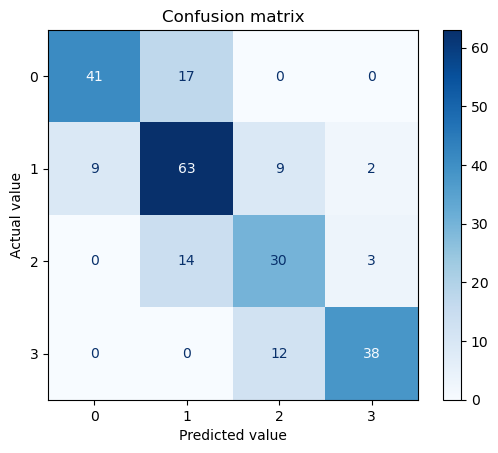

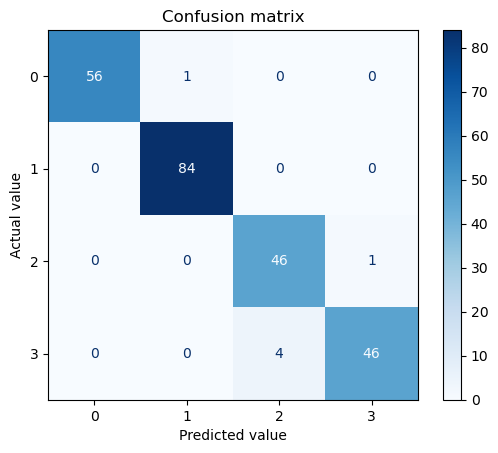

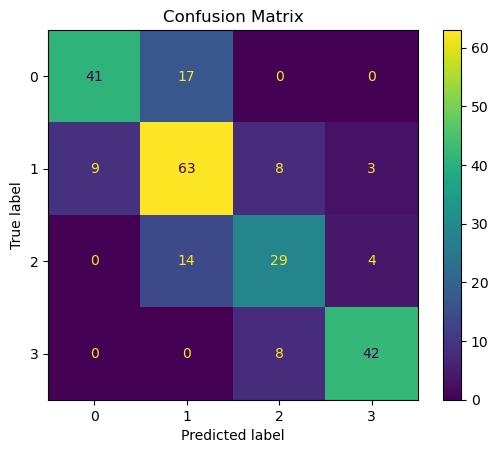

C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:291: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'accuracy': f'{accuracy:.2f}'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'level': f'level {i}',
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'level': f'level {i}',
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc

              precision    recall  f1-score   support

         0.0       0.82      0.71      0.76        58
         1.0       0.67      0.76      0.71        83
         2.0       0.64      0.62      0.63        47
         3.0       0.86      0.84      0.85        50

    accuracy                           0.74       238
   macro avg       0.75      0.73      0.74       238
weighted avg       0.74      0.74      0.74       238

accuracy：0.74
等級 0：
  precision：0.82
  recall：0.71
  F1 ：0.76

等級 1：
  precision：0.67
  recall：0.76
  F1 ：0.71

等級 2：
  precision：0.64
  recall：0.62
  F1 ：0.63

等級 3：
  precision：0.86
  recall：0.84
  F1 ：0.85

Fold 2


  0%|          | 0/238 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_23520\1754048164.py:43: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = scipy.io.wavfile.read(file)
C:\Users\user\AppData\Local\Temp\ipykernel_23520\3072583500.py:172: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(self.path)
100%|██████████| 238/238 [00:55<00:00,  4.29it/s]


train :  238 ,test :  238


100%|██████████| 238/238 [00:51<00:00,  4.64it/s]


8/8 [==============================] - 2s 138ms/step
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        57
           1       0.58      0.83      0.69        84
           2       0.58      0.38      0.46        47
           3       0.94      0.64      0.76        50

    accuracy                           0.67       238
   macro avg       0.71      0.64      0.65       238
weighted avg       0.69      0.67      0.66       238

8/8 [==============================] - 1s 96ms/step
training predict:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.95      1.00      0.98        83
           2       0.98      0.91      0.95        47
           3       1.00      0.98      0.99        50

    accuracy                           0.98       238
   macro avg       0.98      0.97      0.98       238
weighted avg       0.98      0.98      0.98       238


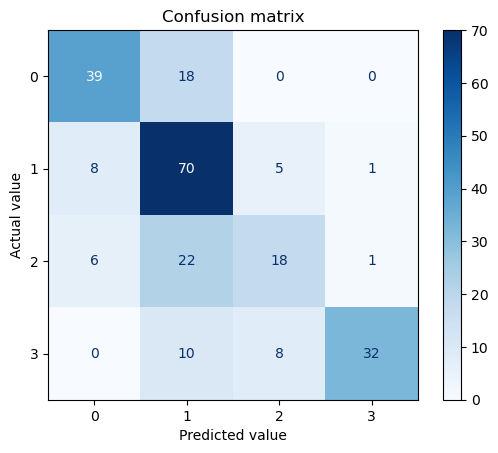

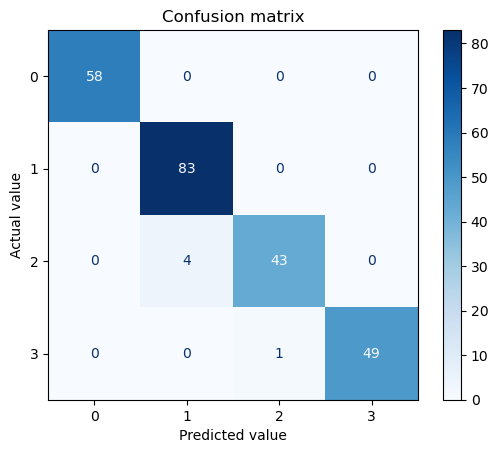

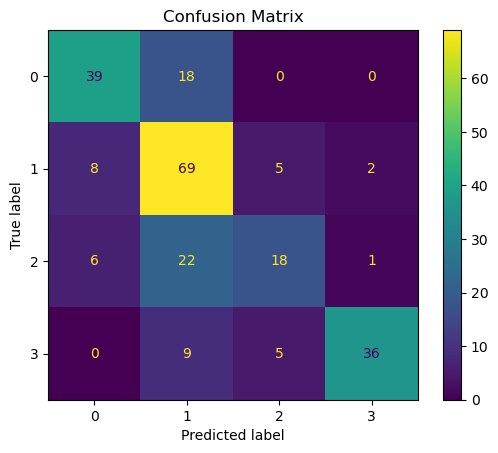

              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71        57
         1.0       0.58      0.82      0.68        84
         2.0       0.64      0.38      0.48        47
         3.0       0.92      0.72      0.81        50

    accuracy                           0.68       238
   macro avg       0.72      0.65      0.67       238
weighted avg       0.70      0.68      0.68       238

accuracy：0.68
等級 0：
  precision：0.74
  recall：0.68
  F1 ：0.71

等級 1：
  precision：0.58
  recall：0.82
  F1 ：0.68

等級 2：
  precision：0.64
  recall：0.38
  F1 ：0.48

等級 3：
  precision：0.92
  recall：0.72
  F1 ：0.81

all fold:
Precision: 0.7149 ± 0.0204
Recall: 0.6954 ± 0.0273
F1 Score: 0.6946 ± 0.0313
Accuracy: 0.6954 ± 0.0273
all fold(new):
Precision: 0.7222 ± 0.0187
Recall: 0.7080 ± 0.0273
F1 Score: 0.7059 ± 0.0302
Accuracy: 0.7080 ± 0.0273
所有以 '0910' 開頭的檔案已移動到 '0910_testing' 資料夾中。


C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:291: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'accuracy': f'{accuracy:.2f}'}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'level': f'level {i}',
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc_csv.append({'level': f'level {i}',
C:\Users\user\AppData\Local\Temp\ipykernel_23520\2726238210.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_csv = acc

In [5]:
nowDate='0910'      #檔名
sample_rate = sr = 16000   # 採樣頻率16k
file_path = ""
wav_path = file_path + 'E13_0705data/'  ### 音檔路徑
#一組
# all_label = pd.read_csv(file_path+'test4_3_11.csv',dtype={'ID': str}) 
# all_label = all_label.head(477)
# all_label['ID'] = all_label['ID'].astype(str).str.zfill(4)
#2fold
train_df= pd.read_csv(file_path+'2_fold_data_set/two_fold_1.csv',dtype={'ID': str}) 
test_df= pd.read_csv(file_path+'2_fold_data_set/two_fold_2.csv',dtype={'ID': str}) 
 
train_df['ID'] = train_df['ID'].astype(str).str.zfill(4)
test_df['ID'] = test_df['ID'].astype(str).str.zfill(4)

X_train_filename = get_full_filenames(train_df, wav_path)
y_train_label = np.array(train_df['E'])
X_test_filename = get_full_filenames(test_df, wav_path)
y_test_label = np.array(test_df['E'])

folds = [(X_train_filename,y_train_label),(X_test_filename,y_test_label)]

#####################################
precision_allList = []
recall_allList = []
f1_allList = []
accuracy_allList = []
precision_newList = []
recall_newList = []
f1_newList = []
accuracy_newList = []
print(len(folds),"training:")
for fold in range(len(folds)):
    print(f"Fold {fold + 1}")
    
    # 多fold也可以用
    X_train_filename = np.concatenate([folds[i][0] for i in range(len(folds)) if i != fold])
    train_label = np.concatenate([folds[i][1] for i in range(len(folds)) if i != fold])
    X_test_filename = folds[fold][0]
    test_label = folds[fold][1]
    
    #找符合rule的等級3(寫檔用)
    rule3TrainList = rule3(X_train_filename,train_label,nowDate+'_train',fold)
    rule3TestList = rule3(X_test_filename,test_label,nowDate+'_test',fold)

    train_audio = process_audio(X_train_filename,sample_rate)
    test_audio = process_audio(X_test_filename,sample_rate)

    # 後面出圖用
    t1 = pd.read_csv(f'{nowDate}_train_ruleResult_fold{fold}.csv',usecols=['ID','label','prediction','method'])
    t2 = pd.read_csv(f'{nowDate}_test_ruleResult_fold{fold}.csv',usecols=['ID','label','prediction','method'])
    df1 = pd.concat([t1, t2], ignore_index=True)
    def correct_id(filename):
        return filename.replace('_', '')

    # 做available的東西(暫時不用)
    # labeldf = pd.read_csv('TwoAvailableResult.csv')
    # labeldf['label'] = labeldf['label'].astype(str)
    # labeldf['fileName'] = labeldf['fileName'].apply(lambda x: correct_id(x))
    ###

    # X_train_filename, X_test_filename, y_train, y_val = train_test_split(new_data_path,new_label,test_size=0.4,random_state=random_number[times],stratify=new_label)  
    print('train : ',len(X_train_filename),',test : ',len(X_test_filename))
    # X = []
    # X1 = []
    # for i in tqdm(X_train_filename):
    #     X.append(MelX[np.where(new_data_path == i)[0][0]])
    # for i in tqdm(X_test_filename):
    #     X1.append(MelX[np.where(new_data_path == i)[0][0]])
    X = []
    X1 = []
    y_train = []
    y_val = []
    
    
    for i in tqdm(range(train_audio.shape[0])):
        spec_obj = af.MelSpectrogram(num=184, samplate=sample_rate, radix2_exp=10)
        spec_arr = spec_obj.spectrogram(train_audio[i])
        spec_dB_arr = af.utils.power_to_db(spec_arr)
        X.append(spec_dB_arr)
        y_train.append(train_label[i])
    X = np.array(X)
    y_train = np.array(y_train)
    
    for i in tqdm(range(test_audio.shape[0])):
        spec_obj = af.MelSpectrogram(num=184, samplate=sample_rate, radix2_exp=10)
        spec_arr = spec_obj.spectrogram(test_audio[i])
        spec_dB_arr = af.utils.power_to_db(spec_arr)
        X1.append(spec_dB_arr)
        y_val.append(test_label[i])
    X1 = np.array(X1)
    y_val = np.array(y_val)

    MelS_x_train = np.stack((X, X, X), axis=3)
    MelS_x_val = np.stack((X1, X1, X1), axis=3)

    MelS_x_train = np.asarray(MelS_x_train)
    y_train = np.asarray(y_train)
    MelS_x_val = np.asarray(MelS_x_val)
    y_val = np.asarray(y_val)
    

    #####  training model  #####
    model_mels = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(184,559,3), pooling='max')  # avg
    layer = tf.keras.models.Model(inputs=model_mels.input, outputs=model_mels.get_layer('block4c_project_conv').output)
    x = layer.output
    x = Dropout(0.25)(x)
    x_sp = spatialAttention_eff(x,kernel_size=4,name="")
    x = residual_block_eff(x_sp,8,3)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1280,kernel_regularizer=regularizers.l2(0.001))(x)
    x = gelu(x)
    x = Dropout(0.1)(x)
    x = Dense(128,kernel_regularizer=regularizers.l2(0.001))(x)
    x = gelu(x)
    output = Dense(units=5, activation='softmax')(x)
    model_mels = tf.keras.models.Model(inputs=model_mels.input, outputs=output)
    lr = 0.00003
    # lr = 0.0001520754931920187
    class_weight = (0.3,0.3,0.3,0.1)

    model_mels.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),   #tf.keras.optimizers.RMSprop(learning_rate=lr,rho=0.9, epsilon=1e-8),  
                loss=SparseCategoricalFocalLoss(gamma=2,class_weight=class_weight) ,# ,class_weight=(0.1,0.15,0.14,0.3,0.31) SparseCategoricalFocalLoss(gamma=2) focal_loss(alpha=.25, gamma=2),sparse_categorical_crossentropy binary_crossentropy
                metrics=['accuracy'])
    batch_size = 16
    epoch = 60
    ####################################


    ### load model ###
    if fold == 0:
        model_mels = keras.models.load_model('0827_2foldFix_train_model_fold0_1.h5')
    elif fold == 1:
        model_mels = keras.models.load_model('0827_2foldFix_train_model_fold1_1.h5')
    # model_mels = keras.models.load_model('0716_model_15_four_class(avalible_model_acc_69)/model_15.h5')######################

    ### training model ###
    # model_history = model_mels.fit([MelS_x_train],y_train,
    #                         validation_data = ([MelS_x_val],y_val), # callbacks=[EarlyStopping(monitor='val_loss', patience=20, mode='auto')],
    #                         batch_size=batch_size,
    #                         epochs=epoch)
    # train_loss = model_history.history['loss']
    # val_loss = model_history.history['val_loss']
    # train_accuracy = model_history.history['accuracy']
    # val_accuracy = model_history.history['val_accuracy']

    # plt.figure()
    # plt.plot(train_loss, label='Training Loss')
    # plt.plot(val_loss, label='Validation Loss')
    # plt.title('Training and Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(f'{nowDate}_fold{fold}_loss_curve.png')

    # plt.figure() 
    # plt.plot(train_accuracy, label='Training Accuracy')
    # plt.plot(val_accuracy, label='Validation Accuracy')
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(f'{nowDate}_fold{fold}_accuracy_curve.png')
    ##########################

    ### predict test set ###
    mfcc_predict = model_mels.predict([MelS_x_val])  
    mfcc_pred = np.argmax(mfcc_predict, axis=-1)
    report = classification_report(y_val, mfcc_pred)  
    print(report)
    class_name = ['0', '1', '2', '3']
    conf = confusion_matrix(y_val, mfcc_pred)
    cm_dfsinc = pd.DataFrame(conf,
                        index = class_name, 
                        columns = class_name)

    model_cm = confusion_matrix(y_val, mfcc_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels=class_name)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted value", color = 'black')
    plt.ylabel("Actual value", color = 'black') 
    plt.savefig(f'{nowDate}_CM_fold{fold}.png')
    # model_mels.save(f'{nowDate}_model_fold{fold}.h5')#########################################################
    resultfile2 = open(f"{nowDate}_modelResult_fold{fold}.csv", "w")
    resultfile2.write("ID,label,prediction,method,Model_proba\n")
    for data in zip(mfcc_pred, y_val, X_test_filename):      
        resultfile2.write(str(data[2][-8:-4]) + "," + str(data[1]) + "," + str(data[0]) + ",model,"  + "\n")
    resultfile2.close()
    
    with open(f'{nowDate}_accReport_fold{fold}.txt', 'w') as f:
        f.write(report)
    ## 儲存trainset的ID和label(暫時不用)
    # ttt = open(f"{nowDate}_testset.csv", "w")
    # ttt.write("ID,E\n")
    # for data in zip(y_val, X_test_filename):      
    #     ttt.write(str(data[1][-8:-4]) + "," + str(data[0]) + "\n")
    # ttt.close()

    #######################

    ### predict train set ###
    train_predict = model_mels.predict([MelS_x_train])  
    train_pred = np.argmax(train_predict, axis=-1)
    trainResultfile = open(f"{nowDate}_trainResult_fold{fold}.csv", "w")
    trainResultfile.write("ID,label,prediction,method\n")
    for data in zip(train_pred, y_train, X_train_filename):      
        trainResultfile.write(str(data[2][-8:-4]) + "," + str(data[1]) + "," + str(data[0]) + ",model,"  + "\n")
    trainResultfile.close()
    print("training predict:")
    train_report = classification_report(y_train, train_pred)  
    print(train_report)
    with open(f'{nowDate}_accReport_train_fold{fold}.txt', 'w') as f:
        f.write(train_report)
    train_class_name = ['0', '1', '2', '3']
    train_conf = confusion_matrix(y_train, train_pred)
    train_cm_dfsinc = pd.DataFrame(conf,
                        index = train_class_name, 
                        columns = train_class_name)

    train_model_cm = confusion_matrix(y_train, train_pred)
    train_disp = ConfusionMatrixDisplay(confusion_matrix=train_model_cm, display_labels=train_class_name)
    train_disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted value", color = 'black')
    plt.ylabel("Actual value", color = 'black') 
    plt.savefig(f'{nowDate}_CM_train_fold{fold}.png')

    ## 儲存trainset的ID和label
    # ttt = open(f"{nowDate}_trainset.csv", "w")
    # ttt.write("ID,E\n")
    # for data in zip(y_train, X_train_filename):      
    #     ttt.write(str(data[1][-8:-4]) + "," + str(data[0]) + "\n")
    # ttt.close()

    #########################

    ### acc存成list ###

    precision_all = precision_score(y_val, mfcc_pred, average='weighted')
    recall_all = recall_score(y_val, mfcc_pred, average='weighted')
    f1_all = f1_score(y_val, mfcc_pred, average='weighted')
    accuracy_all = accuracy_score(y_val, mfcc_pred)

    precision_allList.append(precision_all)
    recall_allList.append(recall_all)
    f1_allList.append(f1_all)
    accuracy_allList.append(accuracy_all)

    # 每個 fold allAcc.txt
    with open(f'{nowDate}_fold{fold}_allAcc.txt', 'w') as file:
        file.write(f'Precision: {precision_all:.4f}\n')
        file.write(f'Recall: {recall_all:.4f}\n')
        file.write(f'F1 Score: {f1_all:.4f}\n')
        file.write(f'Accuracy: {accuracy_all:.4f}\n')

    ############################

    ### 製作加rule的CM ###
        
    df2 = pd.read_csv(f'{nowDate}_modelResult_fold{fold}.csv',usecols=['ID','label','prediction','method'])
    merged_df = df2.merge(df1[['ID', 'label', 'prediction', 'method']], on='ID', how='left', suffixes=('_df2', '_df1'))
    for col in ['label', 'prediction', 'method']:
        merged_df[col] = merged_df[col + '_df1'].combine_first(merged_df[col + '_df2'])
    merged_df = merged_df.drop(columns=[col + '_df1' for col in ['label', 'prediction', 'method']] +
                                    [col + '_df2' for col in ['label', 'prediction', 'method']])
    merged_df.to_csv(f'{nowDate}_model+rule_result_fold{fold}.csv',index=False)
    cm = metrics.confusion_matrix(merged_df['label'], merged_df['prediction'])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=merged_df['label'].unique().sort())
    fig, ax = plt.subplots()
    cm_display.plot(ax=ax, values_format='d')
    plt.title('Confusion Matrix')
    plt.savefig(f'{nowDate}_CM_eB0_fold{fold}.png')
    plt.show()

    new_report = classification_report(merged_df['label'], merged_df['prediction'])  
    print(new_report)
    with open(f'{nowDate}_accReport_new_fold{fold}.txt', 'w') as f:
        f.write(new_report)

    accuracy = metrics.accuracy_score(merged_df['label'],  merged_df['prediction'])
    precision = metrics.precision_score(merged_df['label'],  merged_df['prediction'], average=None)
    recall = metrics.recall_score(merged_df['label'],  merged_df['prediction'], average=None)
    f1 = metrics.f1_score(merged_df['label'],  merged_df['prediction'], average=None)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f'accuracy：{accuracy:.2f}')
    acc_csv = pd.DataFrame(columns=['level', 'precision', 'recall','f1_score'])#
    acc_csv = acc_csv.append({'accuracy': f'{accuracy:.2f}'}, ignore_index=True)
    # print acc
    for i in range(len(precision)):
        print(f'等級 {i }：')
        # print(f'  acc：{class_accuracy[i]:.2f}')
        print(f'  precision：{precision[i]:.2f}')
        print(f'  recall：{recall[i]:.2f}')
        print(f'  F1 ：{f1[i]:.2f}')#
        print()
        acc_csv = acc_csv.append({'level': f'level {i}',
                        'precision': f'{precision[i]:.2f}',
                        'recall': f'{recall[i]:.2f}','f1_score': f'{f1[i]:.2f}'}, ignore_index=True)
    acc_csv.to_csv(f'{nowDate}_acc_eB0_fold{fold}.csv', index=False)
    ########
    ### 製作加rule的Allacc.txt ###

    precision_new = precision_score(merged_df['label'], merged_df['prediction'], average='weighted')
    recall_new = recall_score(merged_df['label'], merged_df['prediction'], average='weighted')
    f1_new = f1_score(merged_df['label'], merged_df['prediction'], average='weighted')
    accuracy_new = accuracy_score(merged_df['label'], merged_df['prediction'])

    precision_newList.append(precision_new)
    recall_newList.append(recall_new)
    f1_newList.append(f1_new)
    accuracy_newList.append(accuracy_new)

    # 將每個 fold 的指標寫入一個 .txt 檔案
    with open(f'{nowDate}_fold{fold}_newAcc.txt', 'w') as file:
        file.write(f'Precision: {precision_new:.4f}\n')
        file.write(f'Recall: {recall_new:.4f}\n')
        file.write(f'F1 Score: {f1_new:.4f}\n')
        file.write(f'Accuracy: {accuracy_new:.4f}\n')

    ############################

    ######          做available的東西 (暫時不用)       ######
    ########################################################

    # #做available #predict.csv
    # rdf = merged_df
    # rdf['ID'] = rdf['ID'].astype(str).str.zfill(4)
    # rdf['label'] = rdf['label'].astype(str)
    # rdf['prediction'] = rdf['prediction'].astype(str)
    # print(rdf)

    # changelabeldf = pd.DataFrame(columns=['ID','old_label','label', 'prediction','method'])
    # for i in range(len(rdf['ID'])):

    #     try:
    #         row_index = labeldf[labeldf['fileName'].str.contains(rdf['ID'][i])].index[0]
    #         # print(rdf['ID'][i])
    #         # print(rdf['prediction'][i],labeldf.iloc[row_index]['label'])
    #         if rdf['prediction'][i] == rdf['label'][i]:
    #             temp_df = pd.DataFrame({'ID': [rdf['ID'][i]], 'old_label': [rdf['label'][i]], 'label':[rdf['label'][i]], 'prediction':[rdf['prediction'][i]], 'method':[rdf['method'][i]] })
    #             changelabeldf =pd.concat([changelabeldf, temp_df], ignore_index=True)

    #         elif rdf['prediction'][i] in labeldf.iloc[row_index]['label'] :
    #             temp_df = pd.DataFrame({'ID': [rdf['ID'][i]], 'old_label': [rdf['label'][i]], 'label':[rdf['prediction'][i]], 'prediction':[rdf['prediction'][i]], 'method':[rdf['method'][i]] })
    #             changelabeldf =pd.concat([changelabeldf, temp_df], ignore_index=True)
    #         else:
    #             temp_df = pd.DataFrame({'ID': [rdf['ID'][i]], 'old_label': [rdf['label'][i]], 'label':[rdf['label'][i]], 'prediction':[rdf['prediction'][i]], 'method':[rdf['method'][i]] })
    #             changelabeldf =pd.concat([changelabeldf, temp_df], ignore_index=True)

    #     except:
    #         print('no',rdf['ID'][i])
    #         temp_df = pd.DataFrame({'ID': [rdf['ID'][i]], 'old_label': [rdf['label'][i]], 'label':[rdf['label'][i]], 'prediction':[rdf['prediction'][i]], 'method':[rdf['method'][i]] })
    #         changelabeldf =pd.concat([changelabeldf, temp_df], ignore_index=True)
    #         continue
        
    # changelabeldf.to_csv(f'{nowDate}_predict_fold{fold}.csv',index=False)

    # # dfR2 = pd.read_csv(f'{nowDate}_predict.csv',usecols=['ID','label','prediction','method'])###
    # dfR2 = changelabeldf
    # actual = dfR2['label']
    # predicted = dfR2['prediction']

    # # 創建混淆矩陣
    # cm = metrics.confusion_matrix(actual, predicted)

    # # 使用 ConfusionMatrixDisplay 顯示圖表
    # cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=merged_df['label'].unique().sort())
    # fig, ax = plt.subplots()
    # cm_display.plot(ax=ax, values_format='d')
    # plt.title('Confusion Matrix')
    # plt.savefig(f'{nowDate}_CM_eB0_available_fold{fold}.png')###########################
    # plt.show()
    # accuracy = metrics.accuracy_score(actual, predicted)
    # precision = metrics.precision_score(actual, predicted, average=None)
    # recall = metrics.recall_score(actual, predicted, average=None)
    # f1 = metrics.f1_score(actual, predicted, average=None)
    # class_accuracy = cm.diagonal() / cm.sum(axis=1)
    # # 顯示結果
    # print(f'準確度：{accuracy:.2f}')
    # acc_csv_old = pd.DataFrame(columns=['level', 'precision', 'recall','f1_score'])
    # acc_csv_old = acc_csv_old.append({'accuracy': f'{accuracy:.2f}'}, ignore_index=True)
    # # 顯示每個類別的精確度、召回率和 F1 分數
    # for i in range(len(precision)):
    #     print(f'類別 {i }：')
    #     print(f'  precision：{precision[i]:.2f}')
    #     print(f'  recall：{recall[i]:.2f}')
    #     print(f'  F1：{f1[i]:.2f}')
    #     print()
    #     acc_csv_old = acc_csv_old.append({'level': f'level {i}',
    #                     'precision': f'{precision[i]:.2f}',
    #                     'recall': f'{recall[i]:.2f}','f1_score': f'{f1[i]:.2f}'}, ignore_index=True)
    # acc_csv_old.to_csv(f'{nowDate}_acc_eB0_available_fold{fold}.csv', index=False)
    ########################################################
    ########################################################


print('all fold:')
print(f"Precision: {np.mean(precision_allList):.4f} ± {np.std(precision_allList):.4f}")
print(f"Recall: {np.mean(recall_allList):.4f} ± {np.std(recall_allList):.4f}")
print(f"F1 Score: {np.mean(f1_allList):.4f} ± {np.std(f1_allList):.4f}")
print(f"Accuracy: {np.mean(accuracy_allList):.4f} ± {np.std(accuracy_allList):.4f}")
with open(f'{nowDate}_allAcc.txt', 'w') as file:
    file.write(f'Precision: {np.mean(precision_allList):.4f} ± {np.std(precision_allList):.4f}\n')
    file.write(f'Recall: {np.mean(recall_allList):.4f} ± {np.std(recall_allList):.4f}\n')
    file.write(f'F1 Score: {np.mean(f1_allList):.4f} ± {np.std(f1_allList):.4f}\n')
    file.write(f'Accuracy: {np.mean(accuracy_allList):.4f} ± {np.std(accuracy_allList):.4f}\n')

print('all fold(new):')
print(f"Precision: {np.mean(precision_newList):.4f} ± {np.std(precision_newList):.4f}")
print(f"Recall: {np.mean(recall_newList):.4f} ± {np.std(recall_newList):.4f}")
print(f"F1 Score: {np.mean(f1_newList):.4f} ± {np.std(f1_newList):.4f}")
print(f"Accuracy: {np.mean(accuracy_newList):.4f} ± {np.std(accuracy_newList):.4f}")
with open(f'{nowDate}_newAcc.txt', 'w') as file:
    file.write(f'Precision: {np.mean(precision_newList):.4f} ± {np.std(precision_newList):.4f}\n')
    file.write(f'Recall: {np.mean(recall_newList):.4f} ± {np.std(recall_newList):.4f}\n')
    file.write(f'F1 Score: {np.mean(f1_newList):.4f} ± {np.std(f1_newList):.4f}\n')
    file.write(f'Accuracy: {np.mean(accuracy_newList):.4f} ± {np.std(accuracy_newList):.4f}\n')
        
#放入資料夾
current_directory = os.getcwd()

base_folder_name = f'{nowDate}_testing'
target_folder = base_folder_name

# 檢查並確保資料夾名稱唯一
counter = 1
while os.path.exists(target_folder):
    print(f"資料夾 '{target_folder}' 已經存在。")
    target_folder = f'{base_folder_name}_{counter}'
    counter += 1

# 建立目標資料夾
os.makedirs(target_folder)

# 搜尋並移動符合條件的檔案
for file_name in os.listdir(current_directory):
    # 檢查檔案是否以 nowDate 開頭且擁有指定的副檔名
    if file_name.startswith(nowDate) and any(file_name.endswith(ext) for ext in ['.csv', '.png', '.txt', '.h5']):
        # 建立完整的來源和目標檔案路徑
        source_path = os.path.join(current_directory, file_name)
        destination_path = os.path.join(target_folder, file_name)
        
        # 移動檔案
        shutil.move(source_path, destination_path)

print(f"所有以 '{nowDate}' 開頭的檔案已移動到 '{target_folder}' 資料夾中。")

In [ ]:
train_audio_files